**Default Prophet Model with additional regressor**

**Contains all default parameters and takes 6 days data to forecast 1 day** 

**Training Phase**

15:44:54 - cmdstanpy - INFO - Chain [1] start processing
15:44:55 - cmdstanpy - INFO - Chain [1] done processing
15:44:55 - cmdstanpy - INFO - Chain [1] start processing
15:44:55 - cmdstanpy - INFO - Chain [1] done processing


  regressor  regressor_mode     center  coef_lower      coef  coef_upper
0      temp  multiplicative  12.369142   -0.002804 -0.002804   -0.002804


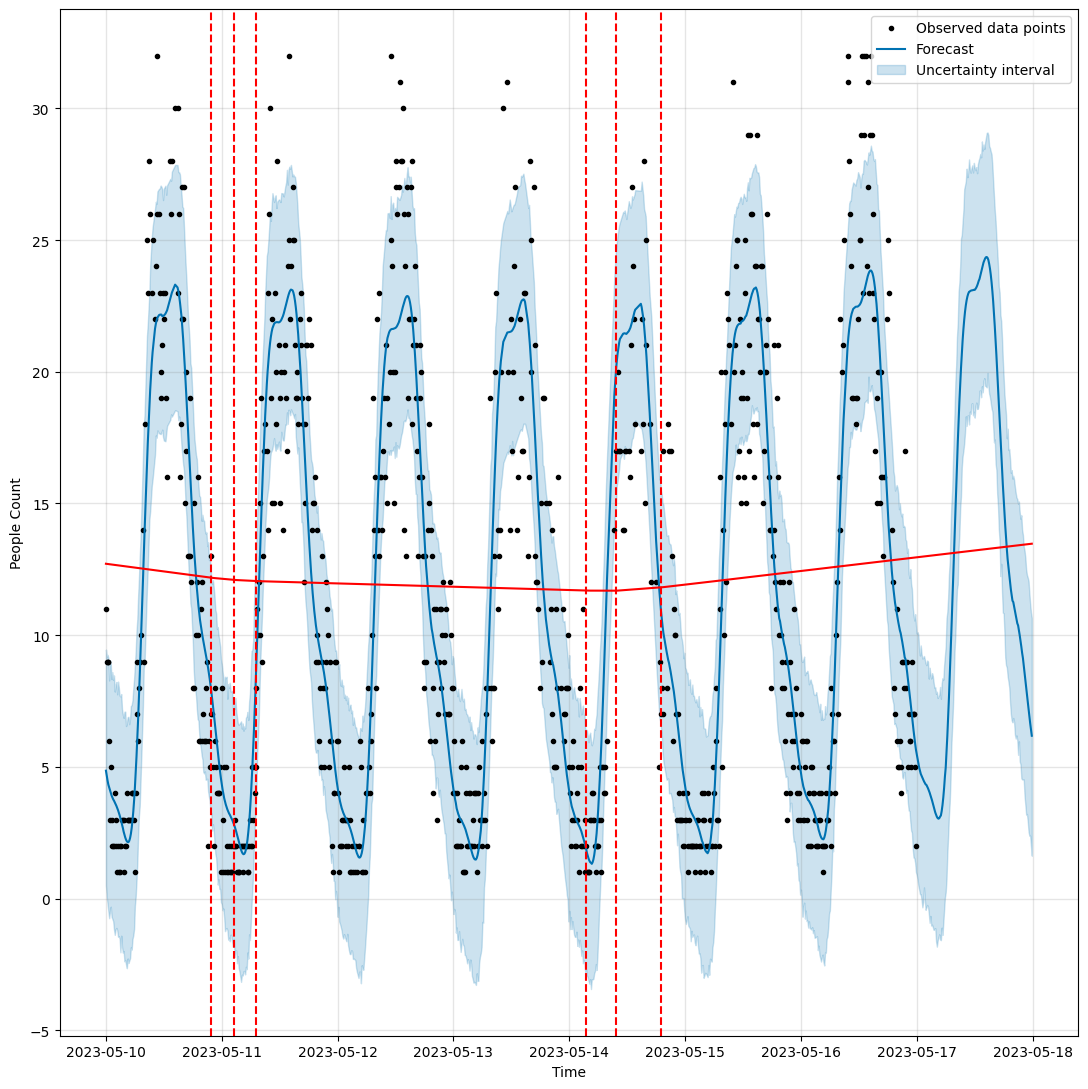

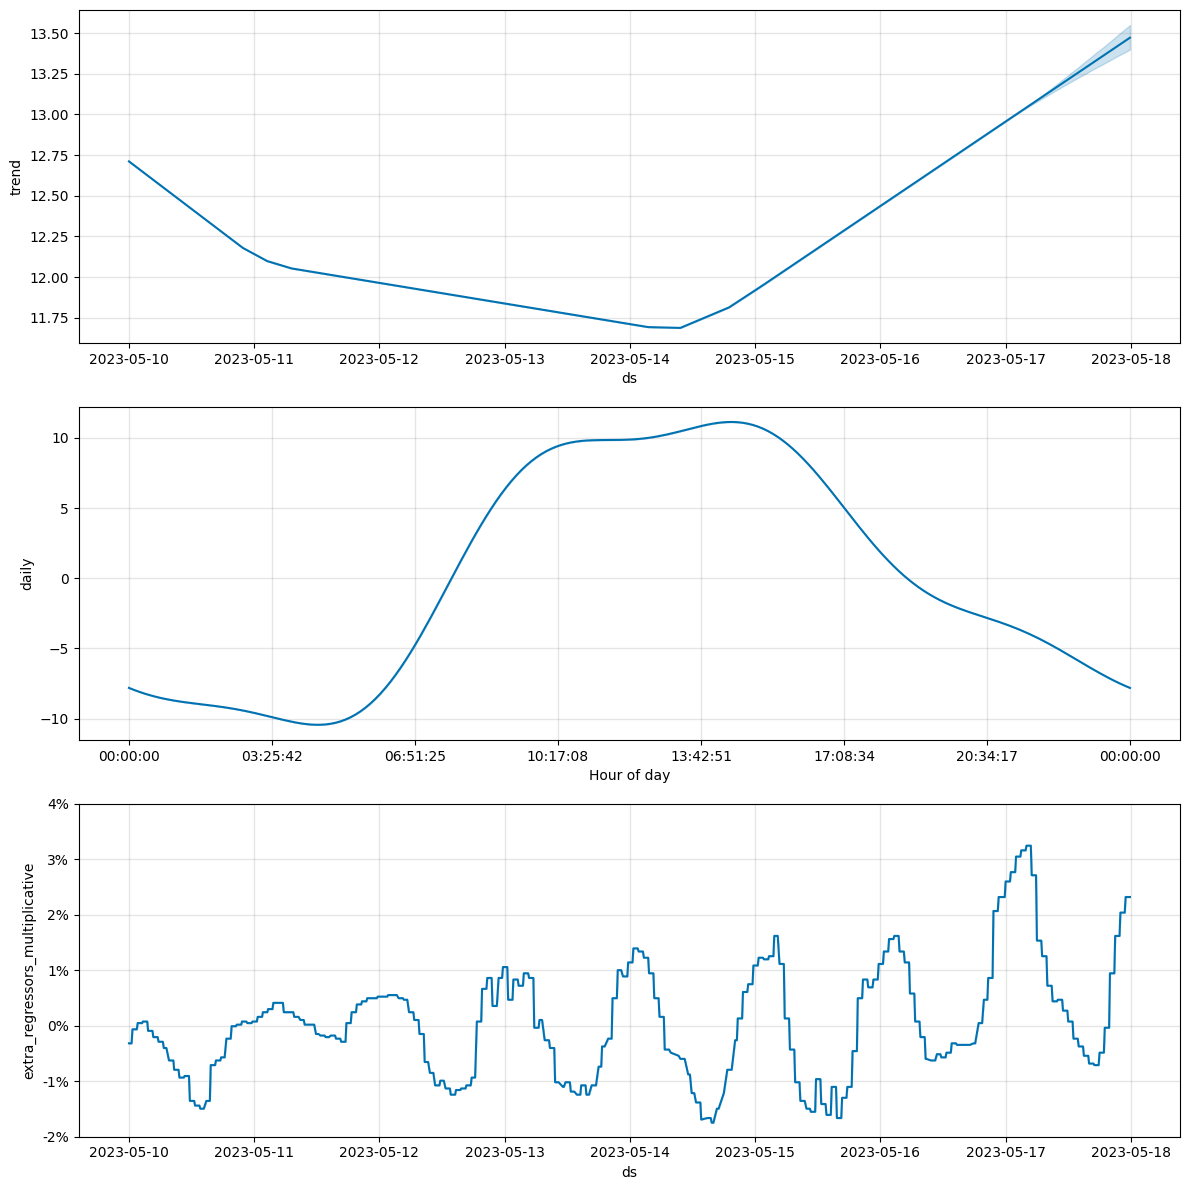

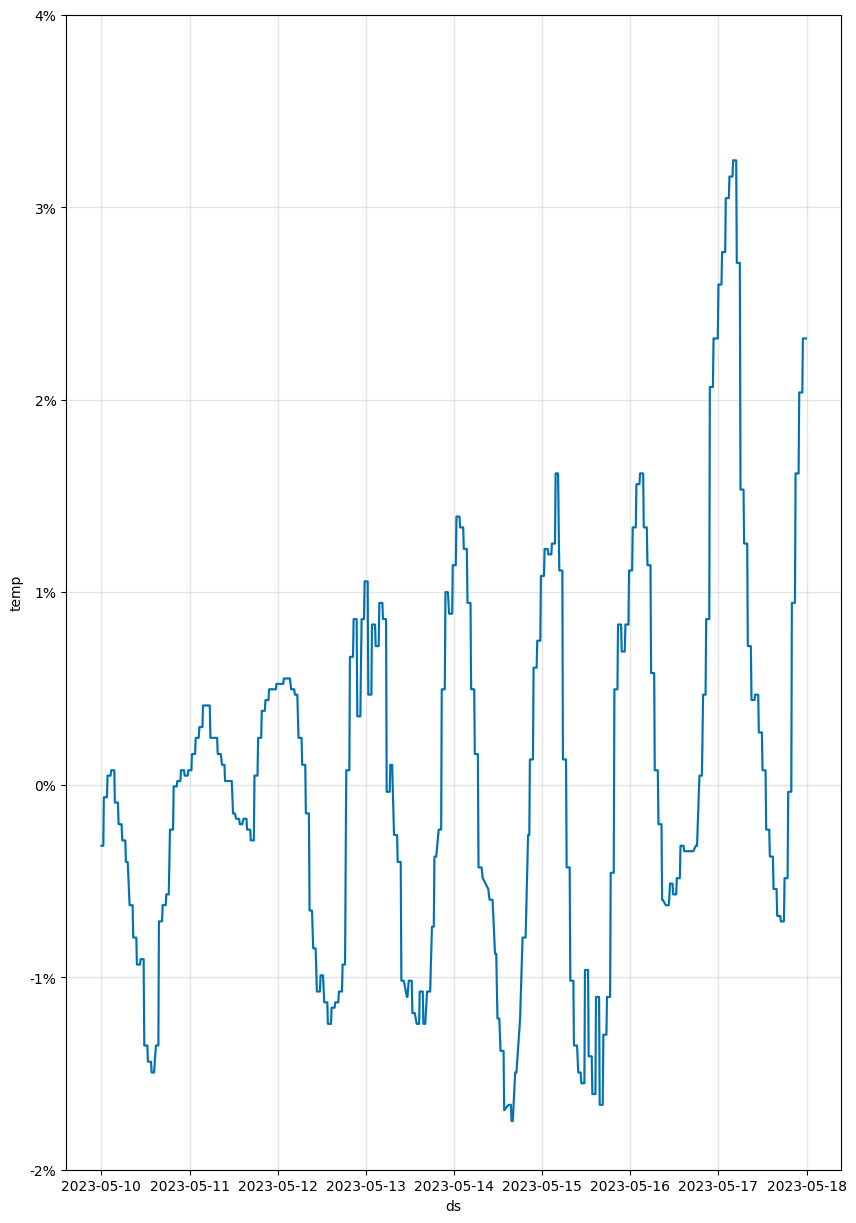

In [63]:
import pandas as pd
import pytz
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from scipy import stats
from meteostat import Hourly
from datetime import datetime
from prophet.utilities import regressor_coefficients
from prophet.plot import plot_forecast_component


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = pd.read_csv('May.csv', parse_dates=['time'])

# Convert to CET and remove timezone information
cet_timezone = pytz.timezone('CET')
df['time'] = df['time'].dt.tz_localize('UTC').dt.tz_convert(cet_timezone).dt.tz_localize(None)

# Choose the start date and end date for the one-week subset
start_date = '2023-05-10 00:00:00'
end_date = '2023-05-16 23:59:59'

# Filter the DataFrame to include only the data for the selected week
selected_week_data = df[(df['time'] >= start_date) & (df['time'] <= end_date)]
# Reset the index and drop the old index (unnamed column)
selected_week_data = selected_week_data.reset_index(drop=True).drop(columns=['Unnamed: 0'])


start = datetime.strptime(start_date,'%Y-%m-%d %H:%M:%S')
end = datetime.strptime(end_date,'%Y-%m-%d %H:%M:%S')

#--------------------------------------------------------------------------------------------#
#Importing weather data from MeteoStat

def fetch_weather_data(location_id, start_date, end_date):
    """
    Fetch weather data for a given location, start date, and end date.

    Parameters:
    - location_id: The location ID for the desired location.
    - start_date: The start date for fetching weather data.
    - end_date: The end date for fetching weather data.

    Returns:
    - DataFrame containing weather data.
    """

    # Fetch weather data using meteostat library
    data = Hourly(location_id, start_date, end_date)
    weather_data = data.fetch().reset_index()
    weather_data = weather_data[['time', 'temp', 'coco']]

    return weather_data

#--------------------------------------------------------------------------------------------#
# Function to  preprocess data
def pre_process_weather_data(input_df):
    """
    Process weather data to create additional columns.

    Parameters:
    - input_df (pd.DataFrame): Input DataFrame containing weather data with columns 'coco', 'temp', and others.

    Returns:
    - pd.DataFrame: Modified DataFrame with additional columns 'clear', 'hot', 'cloudy', 'rain_or_snow'.
    """
    # Create new columns
    input_df['clear'] = 0
    input_df['hot'] = 0
    input_df['cloudy'] = 0
    input_df['rain_or_snow'] = 0

    # Populate the new columns based on the conditions
    input_df.loc[input_df['coco'].isin([1, 2]), 'clear'] = 1
    input_df.loc[input_df['temp'] >= 20, 'hot'] = 1
    input_df.loc[input_df['coco'].isin([3, 4]), 'cloudy'] = 1
    input_df.loc[input_df['coco'].isin(range(9, 28)), 'rain_or_snow'] = 1

    # Drop the original 'coco' column as it is no longer required
    processed_df = input_df.drop('coco', axis=1)

    return processed_df
#--------------------------------------------------------------------------------------------#
# Fetch weather data
weather_data = fetch_weather_data(10675,start,end)
# Process the historical weather data
processed_weather_data = pre_process_weather_data(weather_data)

#Get future predictions add 1 second and 24hr to end time
prediction_start_date = pd.to_datetime(end_date) + pd.DateOffset(seconds=1)
prediction_end_date = pd.to_datetime(end_date) + pd.DateOffset(hours=24,seconds=1)

# Fetch future weather data
predicted_data = fetch_weather_data(10675,prediction_start_date,prediction_end_date)

# Set the 'time' column as the index and 
# Resample the data to 10-minute intervals and forward-fill missing values
predicted_data = predicted_data.set_index('time').resample('10T').ffill().reset_index()

# Process the future weather data
predicted_weather_data = pre_process_weather_data(predicted_data)
# # Rename the columns to align with each other
predicted_weather_data.columns = ['ds', 'temp', 'clear', 'hot', 'cloudy', 'rain_or_snow']

#--------------------------------------------------------------------------------------------#

# Merging crowd data and weather data on time.
# Merge the two DataFrames based on the 'time' column
merged_data = pd.merge_asof(selected_week_data, processed_weather_data, on='time',direction='nearest')


# # Display the selected week data
# print(selected_week_data)

# Create the training set for prophet
training_set = pd.DataFrame({'ds': merged_data['time'], 
                             'y': merged_data['people_count'], 
                             'temp': merged_data['temp'],
                             'cloudy': merged_data['cloudy']})
#--------------------------------------------------------------------------------------------#

# Initialize and fit the dummy Prophet model for 1 week to remove outliers

dummy_weekly_training_model = Prophet()

dummy_weekly_training_model.fit(training_set)

# Make predictions
dummy_weekly_forecast = dummy_weekly_training_model.predict()

#Filter the outliers
filtered_training_set = training_set[(training_set['y'] > dummy_weekly_forecast['yhat_lower'].values) & (training_set['y'] < dummy_weekly_forecast['yhat_upper'].values)]
#ignore the values which are above and below 90% UI

#--------------------------------------------------------------------------------------------#

# Initialize and fit the Prophet model for 1 week
weekly_training_model = Prophet()

#Adding additional regressors from weather data.

weekly_training_model.add_regressor('temp',prior_scale=10, 
                                    standardize='auto', 
                                    mode='multiplicative')

# weekly_training_model.add_regressor('hot')
# weekly_training_model.add_regressor('rain_or_snow')

weekly_training_model.fit(filtered_training_set)

#--------------------------------------------------------------------------------------------#

# Concatenate the two DataFrames vertically based on the 'time' column
concatenated_data = pd.concat([filtered_training_set, predicted_weather_data], axis=0)

# Reset index to have a continuous index
concatenated_data = concatenated_data.reset_index(drop=True)

# Create a future DataFrame for predictions
future = weekly_training_model.make_future_dataframe(periods=6*24, freq='10min')


# future['clear'] = concatenated_data['clear']

future['temp'] = concatenated_data['temp']

# future['hot'] = concatenated_data['hot']

# future['rain_or_snow'] = concatenated_data['rain_or_snow']

# Make predictions
weekly_forecast = weekly_training_model.predict(future)
#--------------------------------------------------------------------------------------------#

fig = weekly_training_model.plot(weekly_forecast, 
                                 figsize=(11,11), 
                                 include_legend=True, 
                                 xlabel="Time", 
                                 ylabel="People Count")

print(regressor_coefficients(weekly_training_model))
# Plot the forecast


# fig_1 = weekly_training_model.plot(weekly_forecast,figsize=(15,15))
fig_2 = weekly_training_model.plot_components(weekly_forecast,figsize=(12,12))

#Identifying the trend
add_changepoints_to_plot(fig.gca(), weekly_training_model, weekly_forecast)
fig, axes = plt.subplots(len(regressor_coefficients(weekly_training_model)), figsize=(10, 15))
# Ensure axes is an iterable even when there is only one subplot
if len(regressor_coefficients(weekly_training_model)) == 1:
    axes = [axes]
    
for i, regressor in enumerate(regressor_coefficients(weekly_training_model)['regressor']):plot_forecast_component(weekly_training_model,weekly_forecast,regressor,axes[i])

plt.show()

**Default Prophet Model with additional regressor**

**Contains all default parameters and takes 6 days data to forecast 1 day** 

**Testing Phase**

15:45:02 - cmdstanpy - INFO - Chain [1] start processing
15:45:02 - cmdstanpy - INFO - Chain [1] done processing


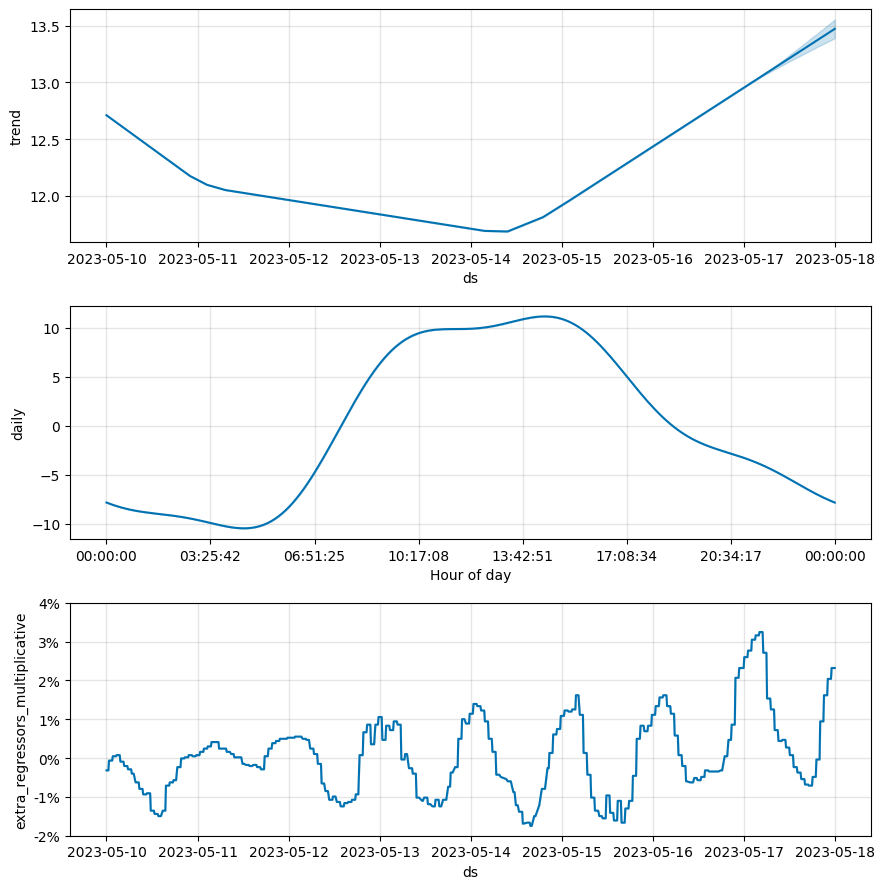

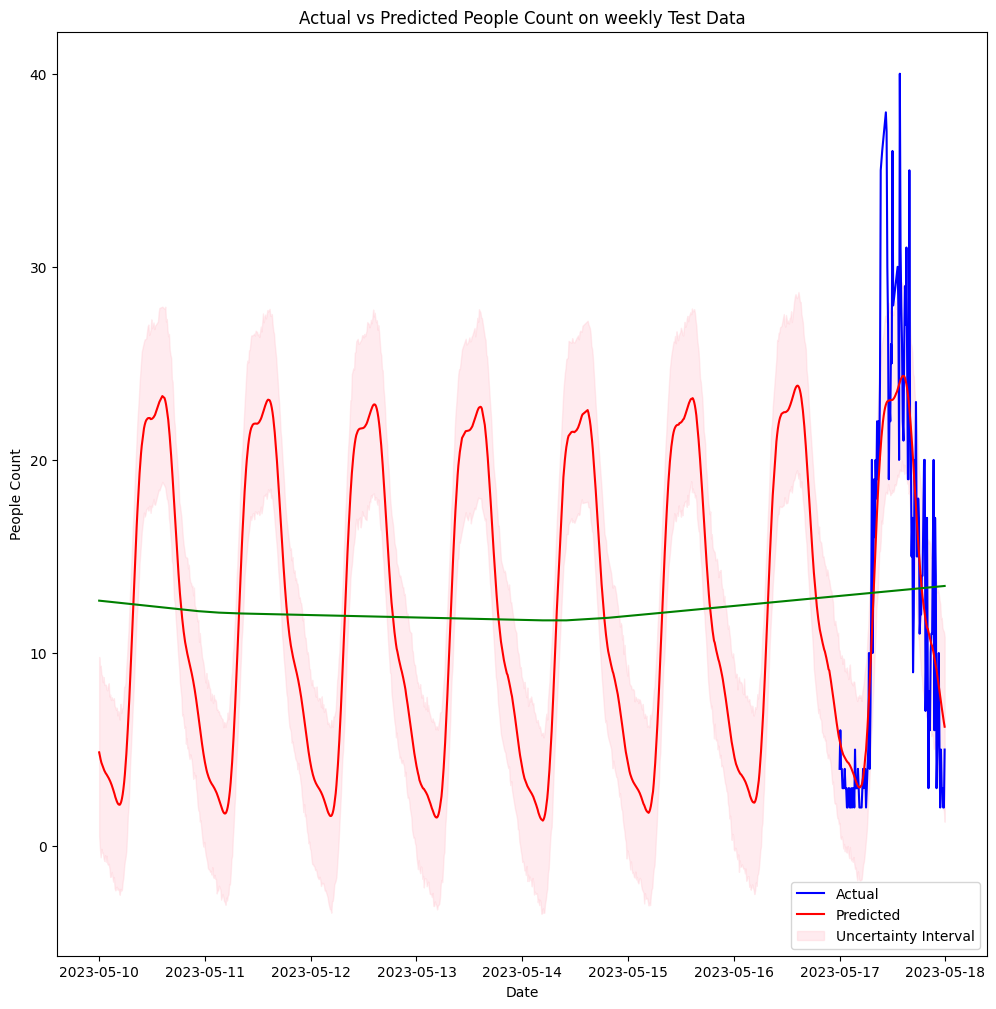

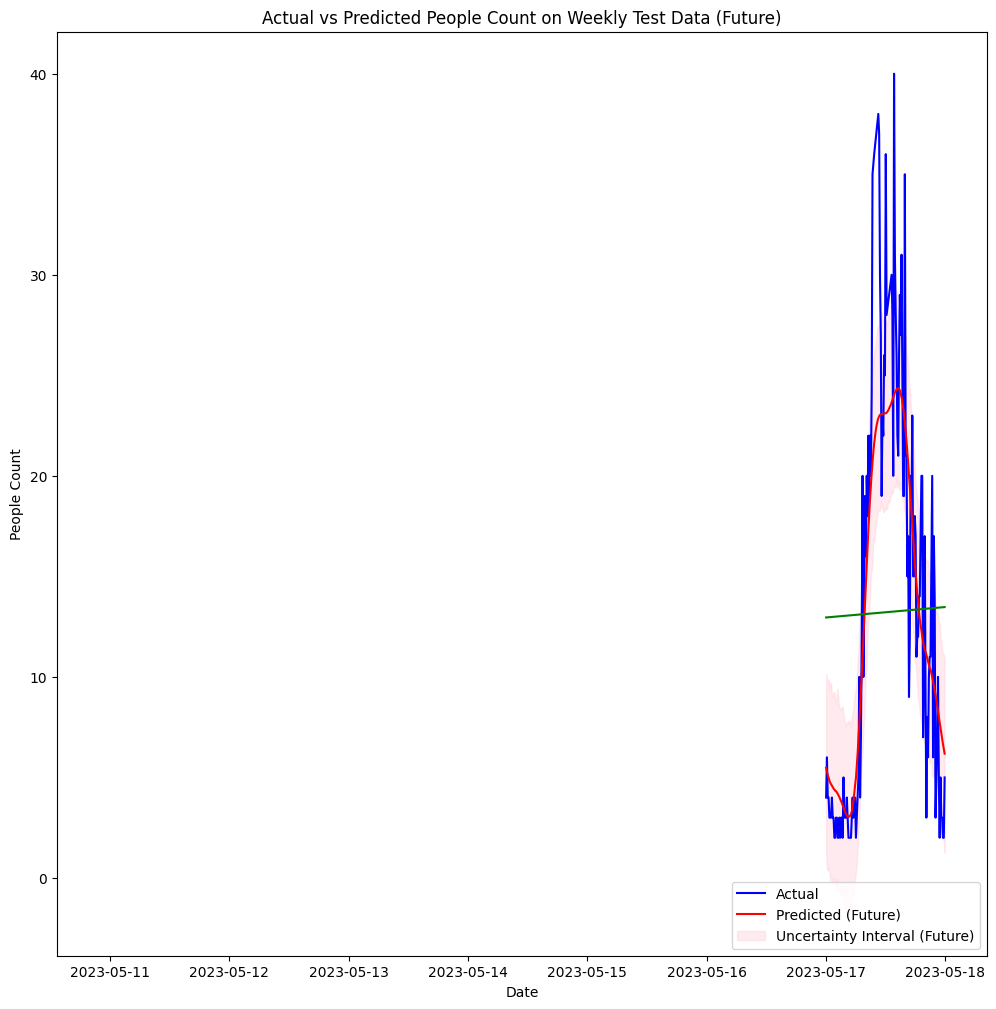

In [64]:
from prophet.plot import plot_components
from datetime import timedelta

# containing datetime values for the test period
df_test = pd.read_csv('May.csv', parse_dates=['time'])


# Convert to CET and remove timezone information
cet_timezone = pytz.timezone('CET')
df_test['time'] = df_test['time'].dt.tz_localize('UTC').dt.tz_convert(cet_timezone).dt.tz_localize(None)


# Choose the start date and end date for the one-week subset
test_start_date = '2023-05-17 00:00:00'
test_end_date = '2023-05-17 23:59:59'

start = datetime.strptime(test_start_date,'%Y-%m-%d %H:%M:%S')
end = datetime.strptime(test_end_date,'%Y-%m-%d %H:%M:%S')


# Filter the DataFrame to include only the data for the selected week
selected_test_data = df_test[(df_test['time'] >= test_start_date) & (df_test['time'] <= test_end_date)]

# Reset the index and drop the old index (unnamed column)
selected_test_data = selected_test_data.reset_index(drop=True).drop(columns=['Unnamed: 0'])


# print(selected_week_data)

# Resample the data to 10-minute intervals and forward-fill missing values

test_weather_data = fetch_weather_data(10675, start, end).set_index('time').resample('10T').ffill().reset_index()

processed_test_data = pre_process_weather_data(test_weather_data)

#--------------------------------------------------------------------------------------------#

# Merging crowd data and weather data on time.
# Merge the two DataFrames based on the 'time' column
merged_test_data = pd.merge_asof(selected_test_data, processed_test_data, on='time',direction='nearest')



# Create the testing set

weekly_testing_set = pd.DataFrame({'ds': merged_test_data['time'], 
                                   'y': merged_test_data['people_count'],
                                    'temp': merged_test_data['temp'], 
                                    'clear': merged_test_data['clear'], 
                                    'cloudy': merged_test_data['cloudy'] })

#Working on dealing with outliers using Error standard deviation
# Initialize and fit the dummy Prophet model for 1 week to remove outliers beyond 95% uncertainity interval

dummy_weekly_testing_model = Prophet()


dummy_weekly_testing_model.fit(weekly_testing_set)

# Make predictions
dummy_weekly_forecast = dummy_weekly_testing_model.predict()

#Filter the outliers
filtered_testing_set = weekly_testing_set[(weekly_testing_set['y'] > dummy_weekly_forecast['yhat_lower'].values) & (weekly_testing_set['y'] < dummy_weekly_forecast['yhat_upper'].values)]
#ignore the values which are above and below 90% UI


# Create a future DataFrame for the test data
one_day_future_test = weekly_training_model.make_future_dataframe(periods=6*24, freq='10min')

# To test the future should also contain all the columns that are used for testing hence merging
one_day_future_test = pd.merge(one_day_future_test, future, on='ds', how='left')


# Make predictions on the test data
weekly_forecast_test = weekly_training_model.predict(one_day_future_test)

fig3 = plot_components(weekly_training_model,weekly_forecast_test)

last_training_date = filtered_training_set['ds'].iloc[-1]
future_predictions = weekly_forecast_test[weekly_forecast_test['ds'] > last_training_date]

# # Plot the actual vs predicted values for the test period
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(filtered_testing_set['ds'], filtered_testing_set['y'], label='Actual', color='blue')
ax.plot(weekly_forecast_test['ds'], weekly_forecast_test['yhat'], label='Predicted', color='red')
ax.fill_between(weekly_forecast_test['ds'], weekly_forecast_test['yhat_lower'], weekly_forecast_test['yhat_upper'], color='pink', alpha=0.3, label='Uncertainty Interval')
ax.legend()
plt.xlabel('Date')
plt.ylabel('People Count')
plt.title('Actual vs Predicted People Count on weekly Test Data')
add_changepoints_to_plot(fig.gca(), weekly_training_model, weekly_forecast_test,cp_linestyle='',cp_color='green')
plt.show()

# Plot the actual vs predicted values for the future period
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(filtered_testing_set['ds'], filtered_testing_set['y'], label='Actual', color='blue')

# Plot only the future predictions
ax.plot(future_predictions['ds'], future_predictions['yhat'], label='Predicted (Future)', color='red')

ax.fill_between(future_predictions['ds'],
                future_predictions['yhat_lower'],
                future_predictions['yhat_upper'],
                color='pink', alpha=0.3, label='Uncertainty Interval (Future)')

ax.legend()
plt.xlabel('Date')
plt.ylabel('People Count')
plt.title('Actual vs Predicted People Count on Weekly Test Data (Future)')
add_changepoints_to_plot(fig.gca(), weekly_training_model, future_predictions, cp_linestyle='', cp_color='green')
plt.show()

**Default Prophet Model with additional regressor**

**Contains all default parameters and takes 6 days data to forecast 1 day** 

**Validation and Evaluation Phase**

  0%|          | 0/2 [00:00<?, ?it/s]

15:45:10 - cmdstanpy - INFO - Chain [1] start processing
15:45:10 - cmdstanpy - INFO - Chain [1] done processing
15:45:10 - cmdstanpy - INFO - Chain [1] start processing
15:45:10 - cmdstanpy - INFO - Chain [1] done processing


  horizon        mse      rmse       mae      mape     mdape     smape  \
0  1 days  16.036757  4.004592  2.870745  0.309159  0.242684  0.298126   

   coverage  
0  0.796154  


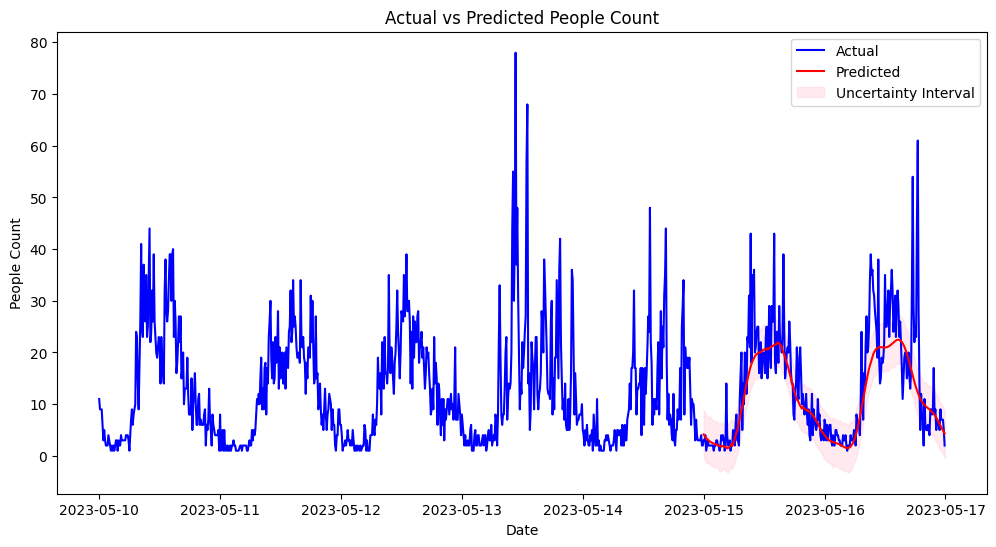

In [65]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics



model_with_regressor_cv = cross_validation(weekly_training_model, horizon= '1 days', period='1 days', initial='4 days')

# # Evaluate model performance

df_p = performance_metrics(model_with_regressor_cv,rolling_window=5)
print(df_p)

# Extract relevant columns from df
actual_data = training_set[['ds', 'y']]

# Extract relevant columns from df_cv
predicted_data = model_with_regressor_cv[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(actual_data['ds'], actual_data['y'], label='Actual', color='blue')
plt.plot(predicted_data['ds'], predicted_data['yhat'], label='Predicted', color='red')
plt.fill_between(predicted_data['ds'], predicted_data['yhat_lower'], predicted_data['yhat_upper'], color='pink', alpha=0.3, label='Uncertainty Interval')
plt.xlabel('Date')
plt.ylabel('People Count')
plt.title('Actual vs Predicted People Count')
plt.legend()